# Hierarchical Clustering of Lung Cancer Coabundance Networks

Depndencies are hell for this package so we recommend just running inside a container.

To run jupyter notebooks from inside the docker image, you need to forward the necessary ports to the container, so that your native browser can connect to it at http://localhost:8888/. You need first to start an interactive shell session

```bash
#REPO_DIR=$HOME/2021-SC-HCA-LATAM/CONTAINER
REPO_DIR=$HOME/BIONF/sc-luca-explore
docker run -p 8888:8888 -p 6006:6006 -it -w /home/user --volume $REPO_DIR:/home/user/luca\
    tiagopeixoto/graph-tool:release-2.98 bash
```

and then start the notebook server

```bash
jupyter lab --ip 0.0.0.0 --allow-root
```

Or if you are using dev containers in vs code just choose the container for image you once ran. It will save you the time of installing al the dev dependencies from vscode. Beware if you are in root you have to add the `--allow-root` flag.

In [2]:
# ! pacman -S python-pip
! pacman -S --noconfirm python-networkx

resolving dependencies...
looking for conflicting packages...

Package (1)            New Version  Net Change  Download Size

extra/python-networkx  3.5-1         23.46 MiB       3.63 MiB

Total Download Size:    3.63 MiB
Total Installed Size:  23.46 MiB

:: Proceed with installation? [Y/n] 
:: Retrieving packages...
 python-networkx-3.5-1-any downloading...
checking keyring...
checking package integrity...
loading package files...
checking for file conflicts...
:: Processing package changes...
installing python-networkx...
Optional dependencies for python-networkx
    python-lxml: for GraphML XML format
    python-pydot: for graph drawing and graph layout algorithms in pure Python via GraphViz
    python-pygraphviz: for graph drawing and graph layout algorithms with bindings to GraphViz
    python-sympy: for polynomial algorithms
:: Running post-transaction hooks...
(1/1) Arming ConditionNeedsUpdate...


In [19]:
import json
from pathlib import Path
import numpy as np
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

plt.switch_backend("cairo")

import pickle
import networkx as nx
import graph_tool.all as gt


In [ ]:
# net_folder = '/root/host_home/luca/outputARACNE/'
net_folder = '/home/user/luca/outputARACNE/'

In [46]:
from matplotlib.lines import Line2D

def _locate_metadata(filename="cell_mappings.json") -> Path:
    search_path = Path.cwd()
    for candidate_dir in [search_path, *search_path.parents]:
        candidate = candidate_dir / "metadata" / filename
        if candidate.exists():
            return candidate
    fallback = Path("/root/host_home/sc-luca-explore/metadata") / filename
    if fallback.exists():
        return fallback
    raise FileNotFoundError(f"Could not find {filename} starting from {search_path}")

metadata_path = _locate_metadata()
with metadata_path.open() as fh:
    metadata = json.load(fh)

color_map = metadata["color_map"]
cell_categories = metadata["cell_categories"]

cell_type_to_category = {
    cell_type: category
    for category, cell_types in cell_categories.items()
    for cell_type in cell_types
}

def cell_category_mapping(cell_type):
    if 'Tumor' in cell_type:
        return 'tumoral'
    else:
        return cell_type_to_category[cell_type]


def get_state_from_file(time, net_folder=net_folder, is_networkx=False, remove_neg=False):
    """
    Load a graph and compute its blockmodel state.
    Supports:
      - TXT (your original loaders)
      - PKL: file name pattern G_{time}.pkl containing either a graph_tool.Graph or a networkx.Graph

    Args:
        time: e.g. 'III-IV_1' or 'I-II_0'
        net_folder: folder path
        is_networkx: if True, use the MI_pearson .txt schema; otherwise the simpler .txt schema
        remove_neg: if True, remove edges with ep.sign == 'negative_significant'
    Returns:
        (state, g) where g is a graph_tool.Graph
    """
    txt_simple = os.path.join(net_folder, f'net{time}.txt')
    txt_nxlike = os.path.join(net_folder, f'net{time}_MI_pearson.txt')
    pkl_path   = os.path.join(net_folder, f'G_{time}.pkl')

    # --- CASE 1: Pickle path exists
    if os.path.exists(pkl_path):
        print(f"Loading .pkl graph from: {pkl_path}")
        with open(pkl_path, "rb") as f:
            loaded = pickle.load(f)

        # If it's already a graph_tool Graph, use it
        if isinstance(loaded, gt.Graph):
            g = loaded

        # If it's a NetworkX graph, convert properly
        elif isinstance(loaded, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph)):
            print("Converting NetworkX graph to graph_tool graph...")

            nxg = loaded
            g = gt.Graph(directed=nxg.is_directed())

            # --- create a vertex for every NX node and keep a mapping
            vmap = {}
            for n in nxg.nodes():
                vmap[n] = g.add_vertex()

            # --- optional: store original node names (string)
            vp_name = g.new_vertex_property("string")
            for n, v in vmap.items():
                vp_name[v] = str(n)
            g.vp["name"] = vp_name

            # --- optionally preserve common node attributes if present
            # degree_centrality, betweenness_centrality
            has_deg = any("degree_centrality" in d for _, d in nxg.nodes(data=True))
            has_bet = any("betweenness_centrality" in d for _, d in nxg.nodes(data=True))
            if has_deg:
                vp_deg = g.new_vertex_property("double")
                for n, d in nxg.nodes(data=True):
                    if "degree_centrality" in d:
                        vp_deg[vmap[n]] = float(d["degree_centrality"])
                g.vp["degree_centrality"] = vp_deg
            if has_bet:
                vp_bet = g.new_vertex_property("double")
                for n, d in nxg.nodes(data=True):
                    if "betweenness_centrality" in d:
                        vp_bet[vmap[n]] = float(d["betweenness_centrality"])
                g.vp["betweenness_centrality"] = vp_bet

            # --- add edges, preserving 'weight' if present
            ep_weight = None
            if any(d for *_ , d in nxg.edges(data=True) if "weight" in d):
                ep_weight = g.new_edge_property("double")

            if isinstance(nxg, (nx.MultiGraph, nx.MultiDiGraph)):
                # allow parallel edges
                for u, v, key, d in nxg.edges(keys=True, data=True):
                    e = g.add_edge(vmap[u], vmap[v])
                    if ep_weight is not None:
                        ep_weight[e] = float(d.get("weight", 1.0))
            else:
                for u, v, d in nxg.edges(data=True):
                    e = g.add_edge(vmap[u], vmap[v])
                    if ep_weight is not None:
                        ep_weight[e] = float(d.get("weight", 1.0))

            if ep_weight is not None:
                g.ep["weight"] = ep_weight
                g.ep["MI"] = ep_weight

        else:
            raise TypeError(f"Unsupported object in {pkl_path}: {type(loaded)}")

    # --- CASE 2: Fallback to TXT loaders (original behavior)
    else:
        if not is_networkx:
            file_path = txt_simple
            g = gt.load_graph_from_csv(
                file_path,
                csv_options={"delimiter": "\t"},
                eprop_types=["float"],
                eprop_names=["MI"],
            )
        else:
            file_path = txt_nxlike
            g = gt.load_graph_from_csv(
                file_path,
                csv_options={"delimiter": "\t"},
                eprop_types=["float", "float", "float", "float", "string"],
                eprop_names=["MI", "pvals", "pearson", "pvalue", "sign"],
            )

    # --- De-duplicate edges (kept from your original)
    edges = list(g.edges())
    edge_set = set()
    for e in edges:
        s, t = int(e.source()), int(e.target())
        if (s, t) in edge_set or (t, s) in edge_set:
            g.remove_edge(e)
        else:
            edge_set.add((s, t))

    # --- Optionally remove negative edges if 'sign' exists
    if remove_neg and hasattr(g, "ep") and "sign" in g.ep:
        for e in list(g.edges()):
            if g.ep.sign[e] == "negative_significant":
                g.remove_edge(e)

    # --- Fit SBM
    print(g)
    state = gt.minimize_nested_blockmodel_dl(g)
    entropy_1 = state.entropy()
    entropy_2 = gt.mcmc_anneal(
        state,
        beta_range=(1, 20),
        niter=1500,
        mcmc_equilibrate_args=dict(force_niter=20),
    )

    print("Without annealing: " + str(entropy_1))
    print("With annealing: " + str(entropy_2))

    return state, g



def paint_net_from_state(state, g, time, width_divisor=16, margin=0.25, remove_neg=False):

    # Assign cell category and color
    g.vp.cat = g.new_vertex_property("string")
    g.vp.color = g.new_vertex_property("string")
    for v in g.vertices():
        g.vp.cat[v] = cell_category_mapping(g.vp.name[v])
        g.vp.color[v] = color_map[g.vp.cat[v]]

    e_width = g.new_edge_property("float")
    e_width.a = g.ep.MI.a/width_divisor

    e_gradient = g.new_edge_property("vector<float>")
    for e in g.edges():
        v = e.source()
        rgb = list(mcolors.to_rgba(g.vp.color[v]))
        e_gradient[e] = [   0, rgb[0], rgb[1], rgb[2], 0.7,
                            1, rgb[0], rgb[1], rgb[2], 0.2
                        ]
        
    e_dash = g.new_edge_property("vector<float>")
    if g.ep.get('sign',None):
        for e in g.edges():        
            e.sign = g.ep.sign[e]
            if e.sign == 'positive_significant':
                e_dash[e] = [ 3,3,3 ]
            elif e.sign =='negative_significant':
                e_dash[e] = [ 10,10,10 ]
                # e_width[e] = e_width[e]*10
            else:
                e_dash[e] = [ 1,0, 0 ]

    fig, ax = plt.subplots(figsize=(12, 10))
    a = state.draw( #https://graph-tool.skewed.de/static/doc/autosummary/graph_tool.draw.graph_draw.html 
                vertex_fill_color=g.vp.color,
                edge_pen_width=e_width,
                #  vertex_halo_color=g.vp.color,
                vertex_text=g.vp.name,
                vertex_text_size=8,
                edge_dash_style=e_dash,
                vertex_text_position='centered',
                edge_gradient = e_gradient,
                vertex_pen_width=0.0,
                # vertex_size=gt.prop_to_size(g.degree_property_map("total"), mi=0.01, ma=0.02, power=1),
                mplfig=ax,
    )
    a[0].fit_view(margin=margin, yflip=True)
    ax.set_title(time)
    ax.set_axis_off()

    # Add legend to the plot
    handles = []
    for category, color in color_map.items():
        handles.append(mpatches.Patch(color=color, label=category))
    if not remove_neg:
        neg_dash = Line2D([], [], color='black', linestyle='--', label='negative_pearson')
        handles.append(neg_dash)
    pos_dash = Line2D([], [], color='black', linestyle='dotted', label='positve_pearson')
    handles.append(pos_dash)
    ax.legend(handles=handles, bbox_to_anchor=(1, 0.5), loc='upper left')
    plt.subplots_adjust(right=0.8, left=0.01, bottom=0.01, top=0.95)  # Adjust right margin for the legend


    fig.savefig(f"{net_folder}/graph_{time}.png")
    plt.close(fig)

    return Image(filename=f"{net_folder}/graph_{time}.png")

## Get state Clusters

In [51]:
with open(f'{net_folder}G_I-II_0.pkl', 'rb') as f:
    g = pickle.load(f)
g

In [21]:
net_folder = '/home/user/luca/nb_graphAnalysis/output/'

In [37]:
state_early_0, g_early_0 = get_state_from_file("I-II_0", net_folder=net_folder)

Loading .pkl graph from: /home/user/luca/nb_graphAnalysis/output/G_I-II_0.pkl
Converting NetworkX graph to graph_tool graph...
<Graph object, undirected, with 48 vertices and 113 edges, 3 internal vertex properties, 1 internal edge property, at 0x7f97f46cdf90>
Without annealing: 363.6498691943032
With annealing: (363.6498691943032, 5921516, 89460)


In [38]:
g_early_0.ep['MI'] = g_early_0.ep['weight']

/usr/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:541: UserWarning: Unknown edge attribute: text_size
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


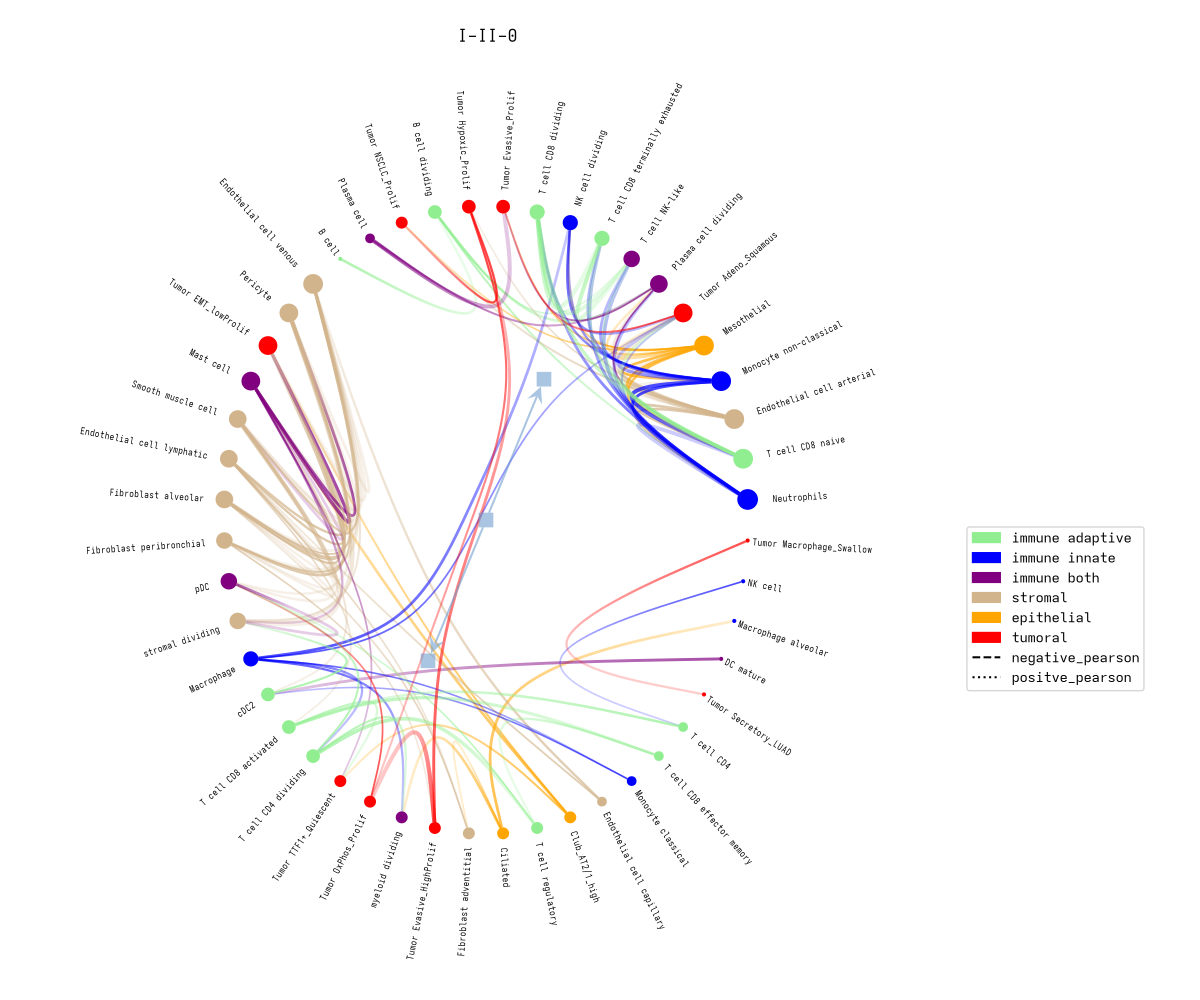

In [47]:
paint_net_from_state(state_early_0, g_early_0, "I-II-0", remove_neg=False, width_divisor=30)

## Get state wu

In [7]:
state_early, g_early = get_state_from_file("I-II_leidenwu_funcnames", is_networkx=True)

state_late, g_late = get_state_from_file("III-IV_leidenwu_funcnames", is_networkx=True)

# Takes 2m12 in docker container

<Graph object, undirected, with 42 vertices and 152 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f980145c5f0>
Without annealing: 426.9022823300671
With annealing: (426.9022823300671, 6779766, 14148)
<Graph object, undirected, with 41 vertices and 131 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f9844c60410>
Without annealing: 358.9123687372106
With annealing: (358.9123687372106, 6675531, 41952)


We used to have repeted edges and this gave us mch more structure. We need to analyze why if this is valid, and why ARACNE does that.

It must be because of the bootstrapping there is a slight difference.... still more exploration could give us some jsutifcation to tkae the repeated edges.

In [8]:
state_early_noneg, g_early_noneg = get_state_from_file("I-II_leidenwu_funcnames", is_networkx=True, remove_neg=True)

state_late_noneg, g_late_noneg = get_state_from_file("III-IV_leidenwu_funcnames", is_networkx=True, remove_neg=True)

<Graph object, undirected, with 42 vertices and 145 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f980143d950>
Without annealing: 416.6475939115145
With annealing: (416.6475939115145, 6856746, 8268)
<Graph object, undirected, with 41 vertices and 129 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f98014847d0>
Without annealing: 356.54278799457904
With annealing: (356.54278799457904, 6552133, 20607)


Without annealing: 416.6475939115145
With annealing: (416.6475939115145, 6581227, 17888)
<Graph object, undirected, with 41 vertices and 129 edges, 1 internal vertex property, 5 internal edge properties, at 0x7fda404c82c0>
Without annealing: 356.54278799457904
With annealing: (356.54278799457904, 6370790, 40246)


### Paint networks

/usr/lib/python3.12/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: text_size
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


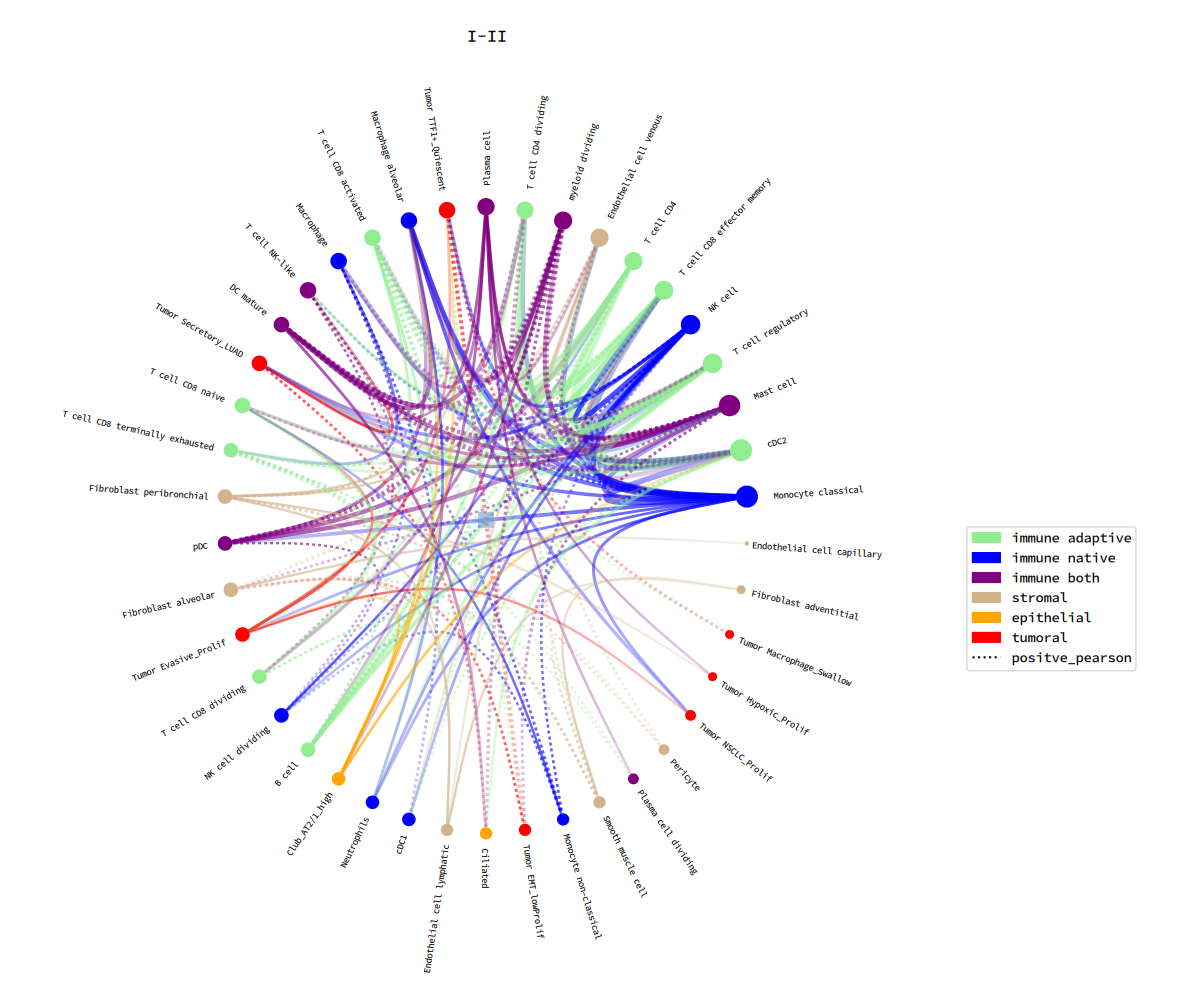

In [5]:
paint_net_from_state(state_early_noneg, g_early_noneg, "I-II", remove_neg=True, width_divisor=30)

/usr/lib/python3.12/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: text_size
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


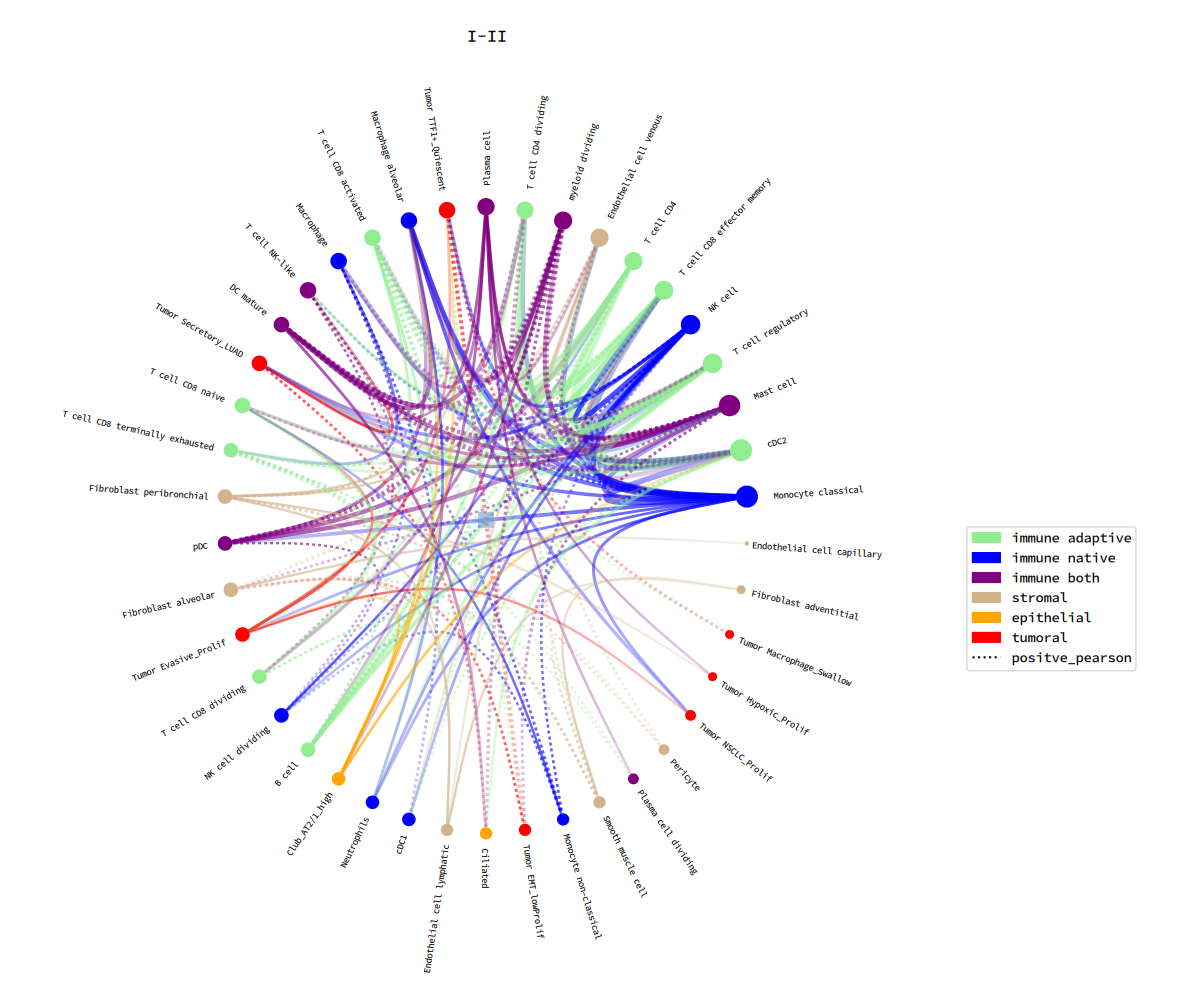

In [5]:
paint_net_from_state(state_early_noneg, g_early_noneg, "I-II", remove_neg=True, width_divisor=30)

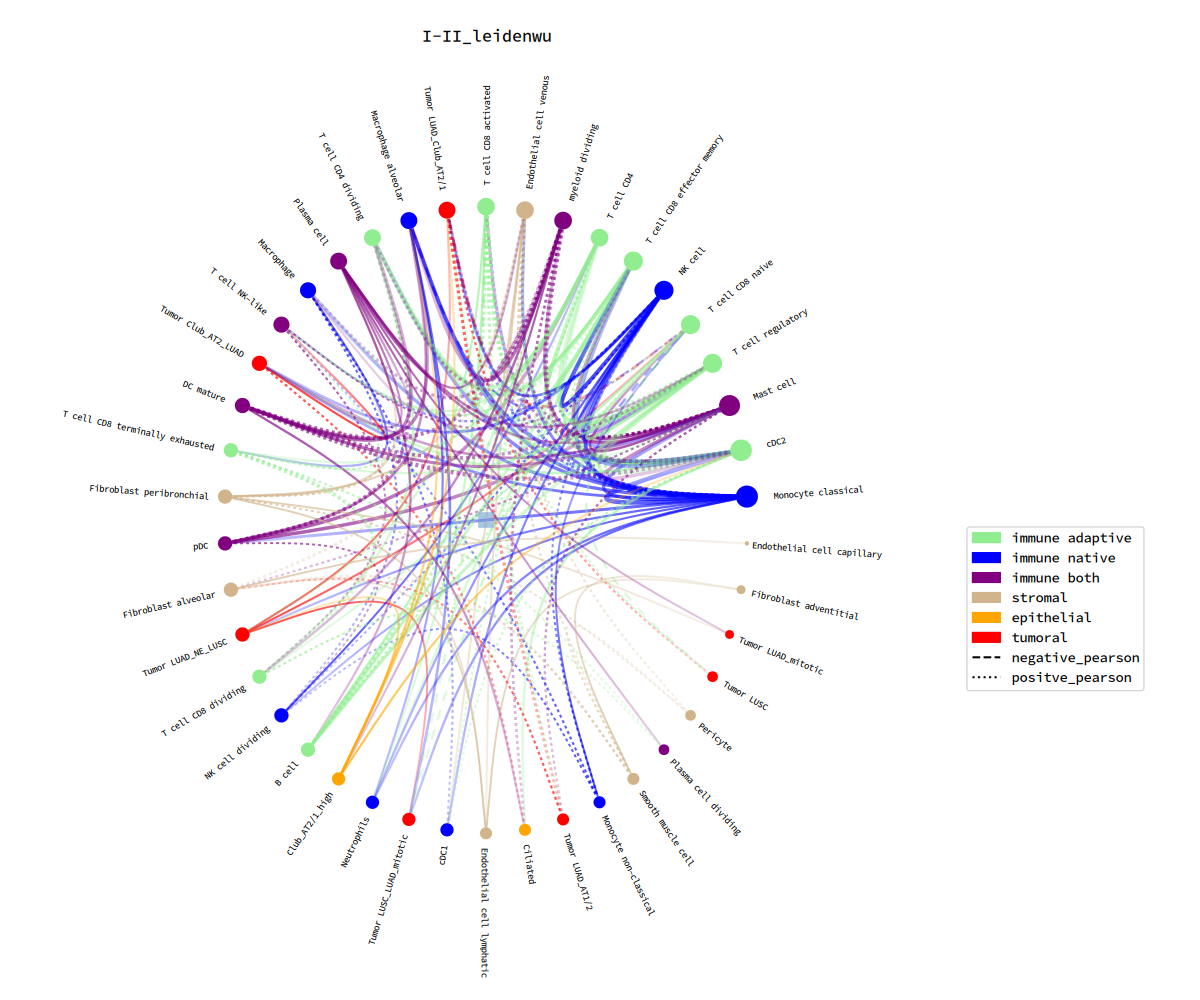

In [16]:
paint_net_from_state(state_early, g_early, "I-II_leidenwu", width_divisor=38)

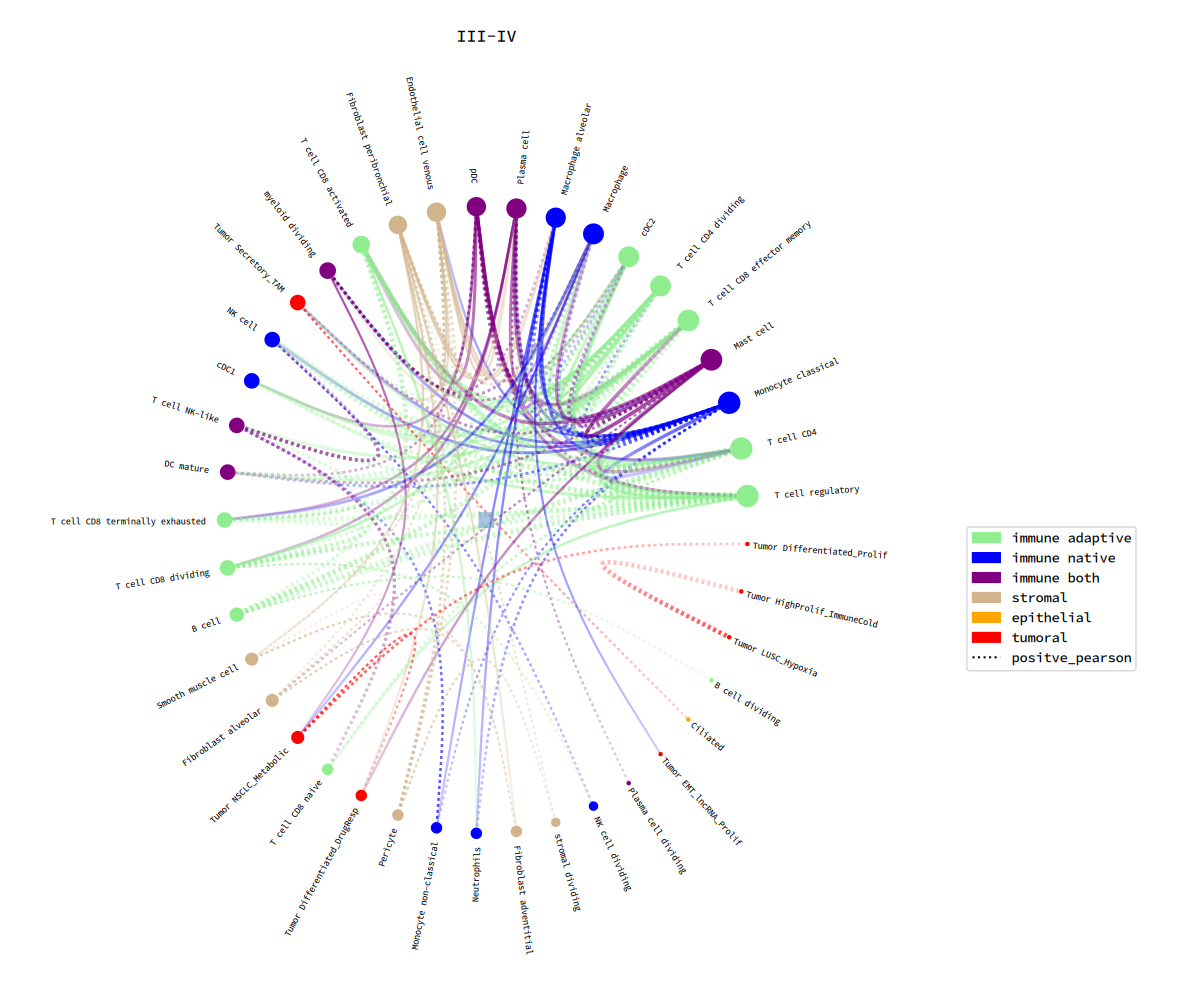

In [6]:
paint_net_from_state(state_late_noneg, g_late_noneg, "III-IV", width_divisor=36, remove_neg=True)

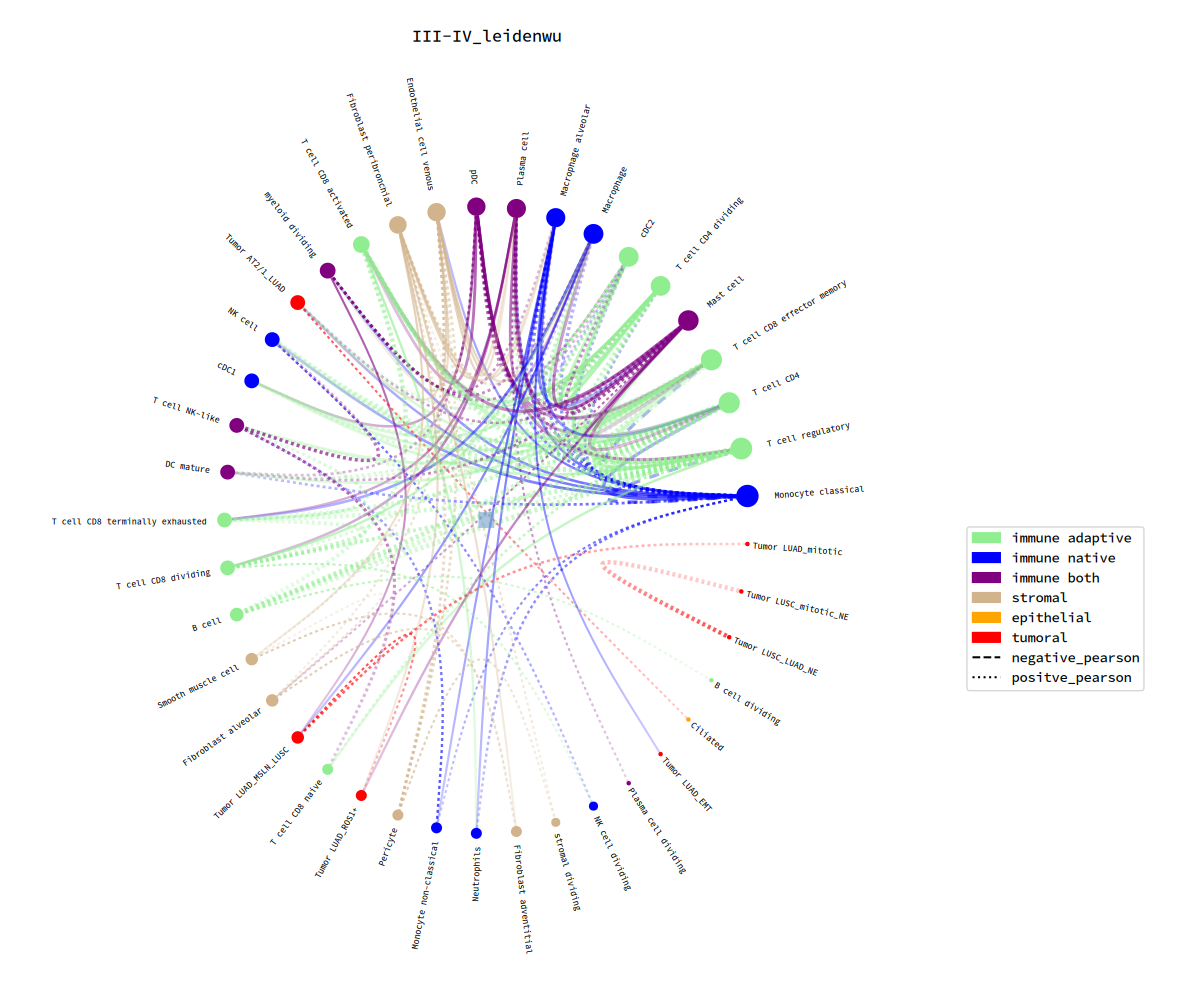

In [18]:
paint_net_from_state(state_late, g_late, "III-IV_leidenwu", width_divisor=38)

## Get state separated

In [9]:
state_early, g_early = get_state_from_file("I-II_leiden2", is_networkx=True)

state_late, g_late = get_state_from_file("III-IV_leiden2", is_networkx=True)

# Takes 2m12 in docker container

<Graph object, undirected, with 47 vertices and 182 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f59040d44a0>
Without annealing: 493.8631904862162
With annealing: (493.86319048621624, 30571091, 89740)
<Graph object, undirected, with 42 vertices and 147 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f590424c200>
Without annealing: 399.4989968583048
With annealing: (397.55160041568115, 27195244, 89778)


We used to have repeted edges and this gave us mch more structure. We need to analyze why if this is valid, and why ARACNE does that.

It must be because of the bootstrapping there is a slight difference.... still more exploration could give us some jsutifcation to tkae the repeated edges.

In [4]:
state_early_noneg, g_early_noneg = get_state_from_file("I-II_leiden2", is_networkx=True, remove_neg=True)

state_late_noneg, g_late_noneg = get_state_from_file("III-IV_leiden2", is_networkx=True, remove_neg=True)

<Graph object, undirected, with 47 vertices and 174 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f30806977d0>
Without annealing: 486.5054171396508
With annealing: (486.5054171396508, 30589791, 66103)


### Paint networks

/usr/lib/python3.12/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: text_size
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


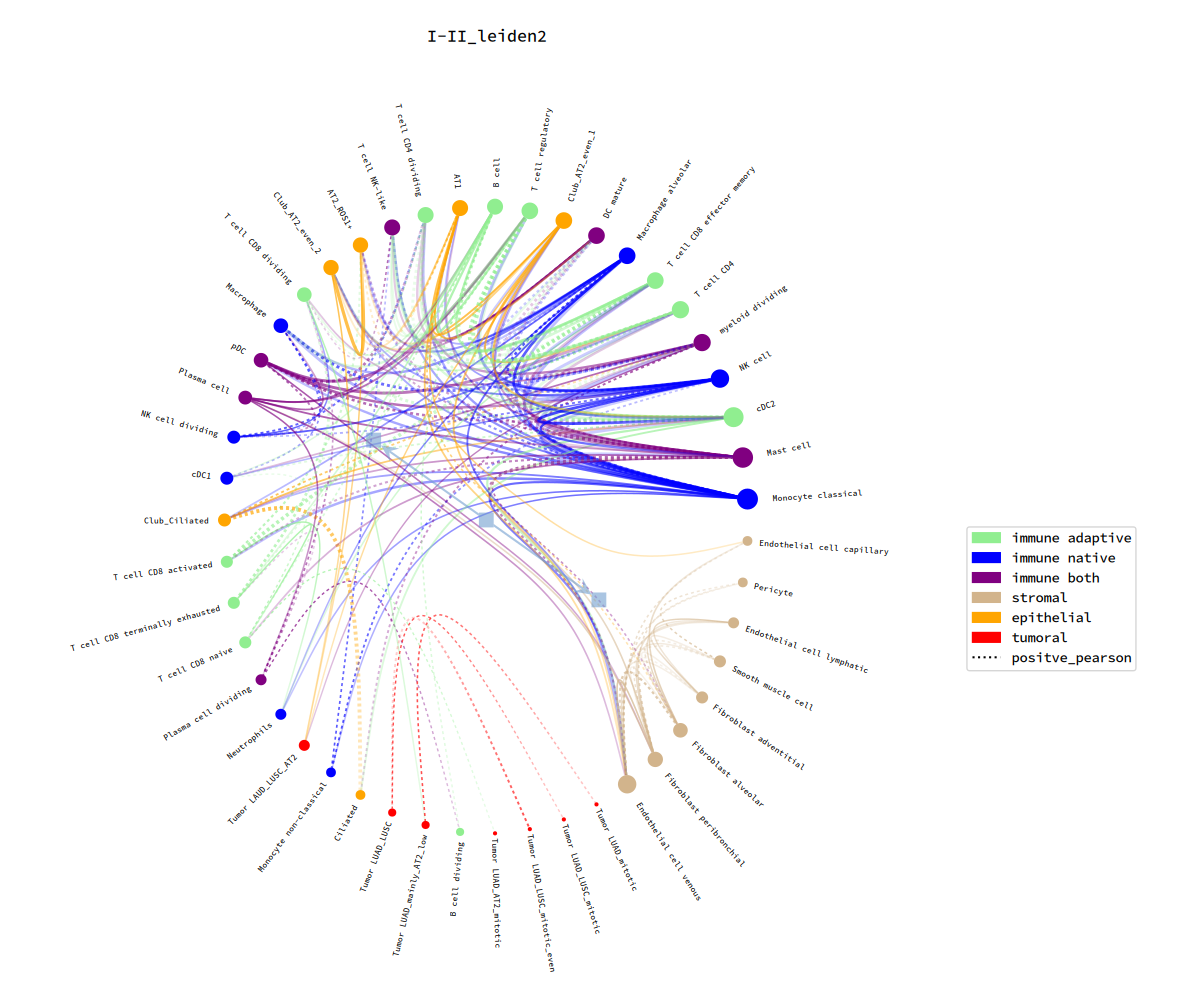

In [6]:
paint_net_from_state(state_early_noneg, g_early_noneg, "I-II_leiden2", remove_neg=True, width_divisor=26)

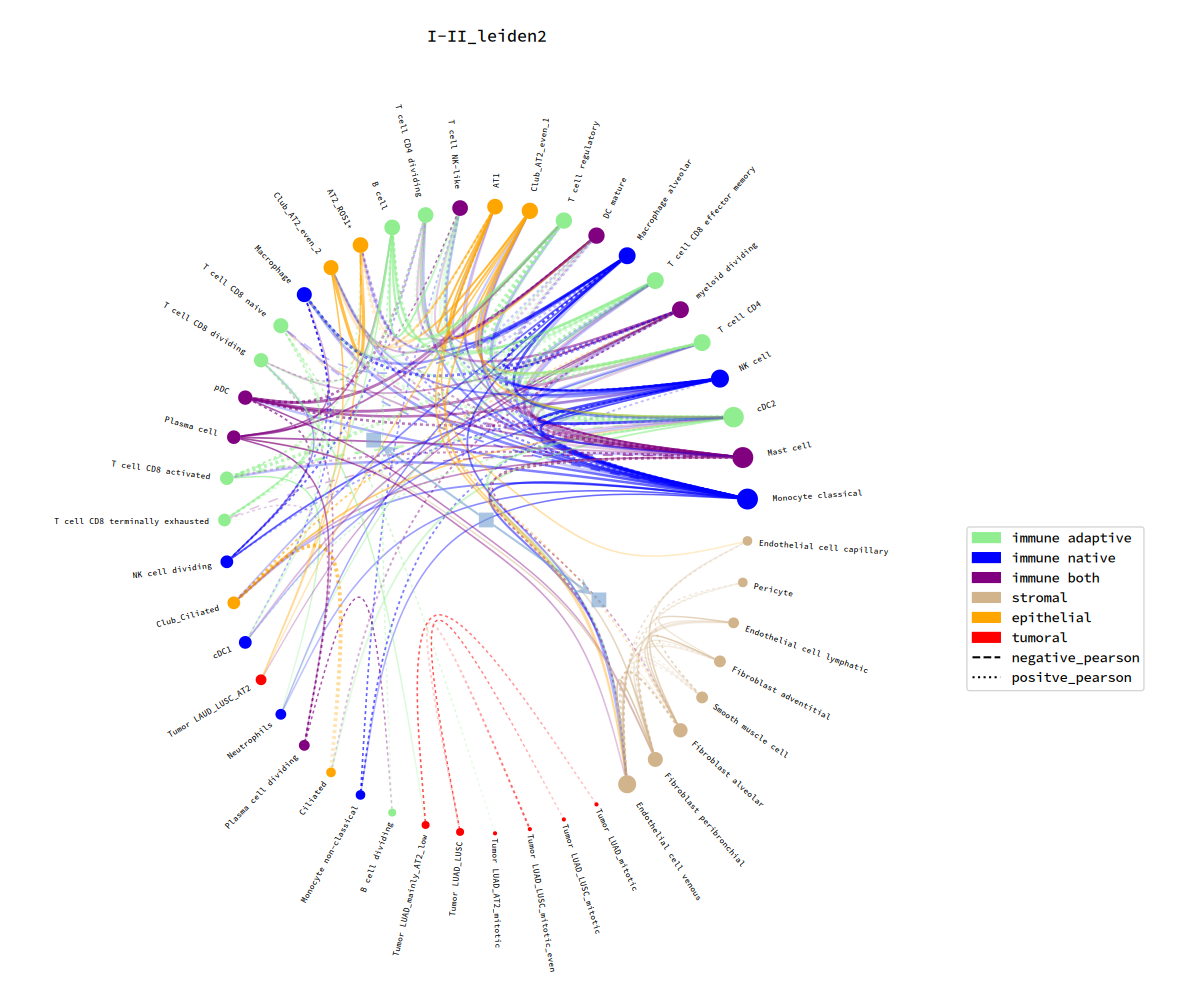

In [19]:
paint_net_from_state(state_early, g_early, "I-II_leiden2", width_divisor=26)

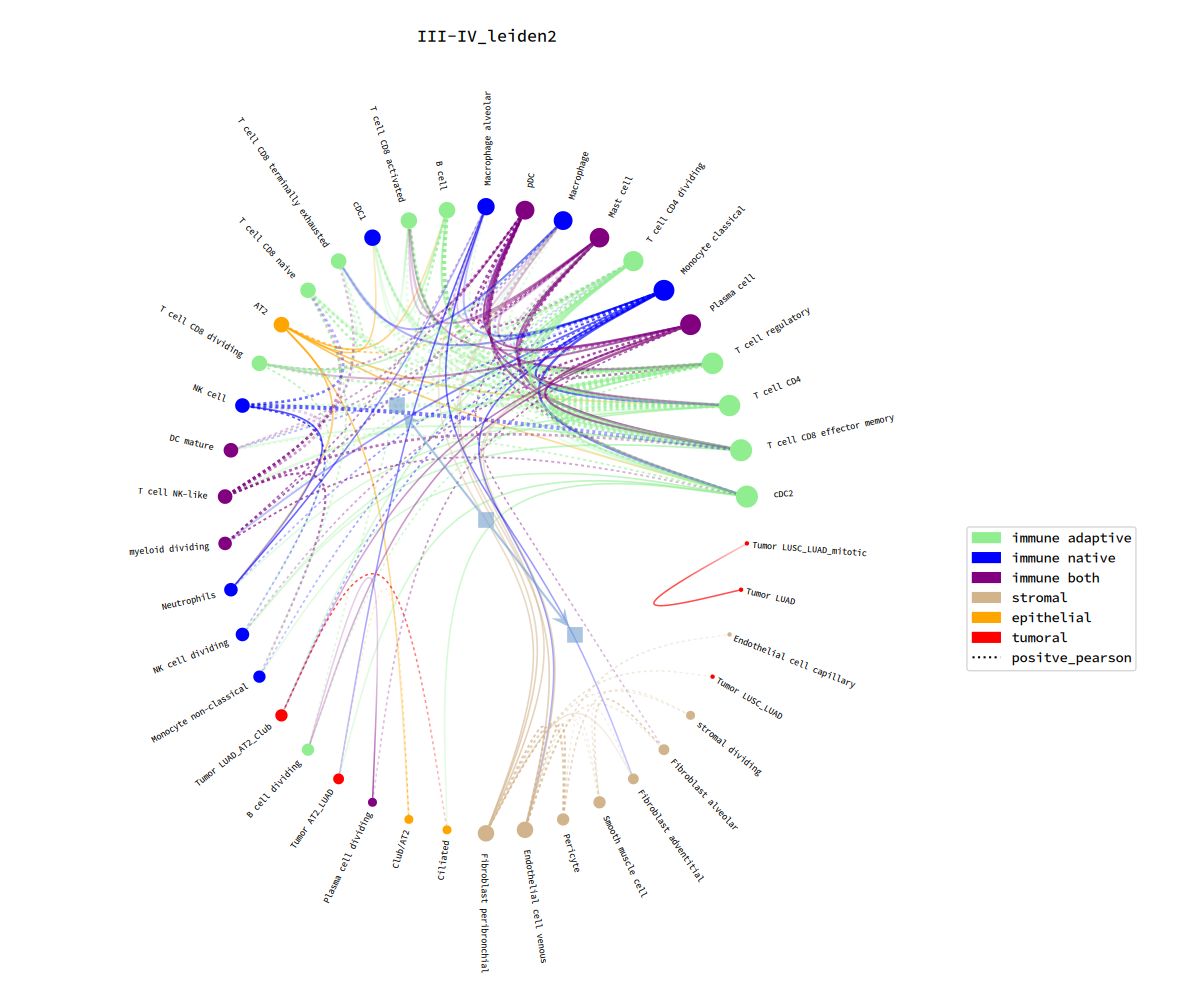

In [18]:
paint_net_from_state(state_late_noneg, g_late_noneg, "III-IV_leiden2", width_divisor=26, remove_neg=True)

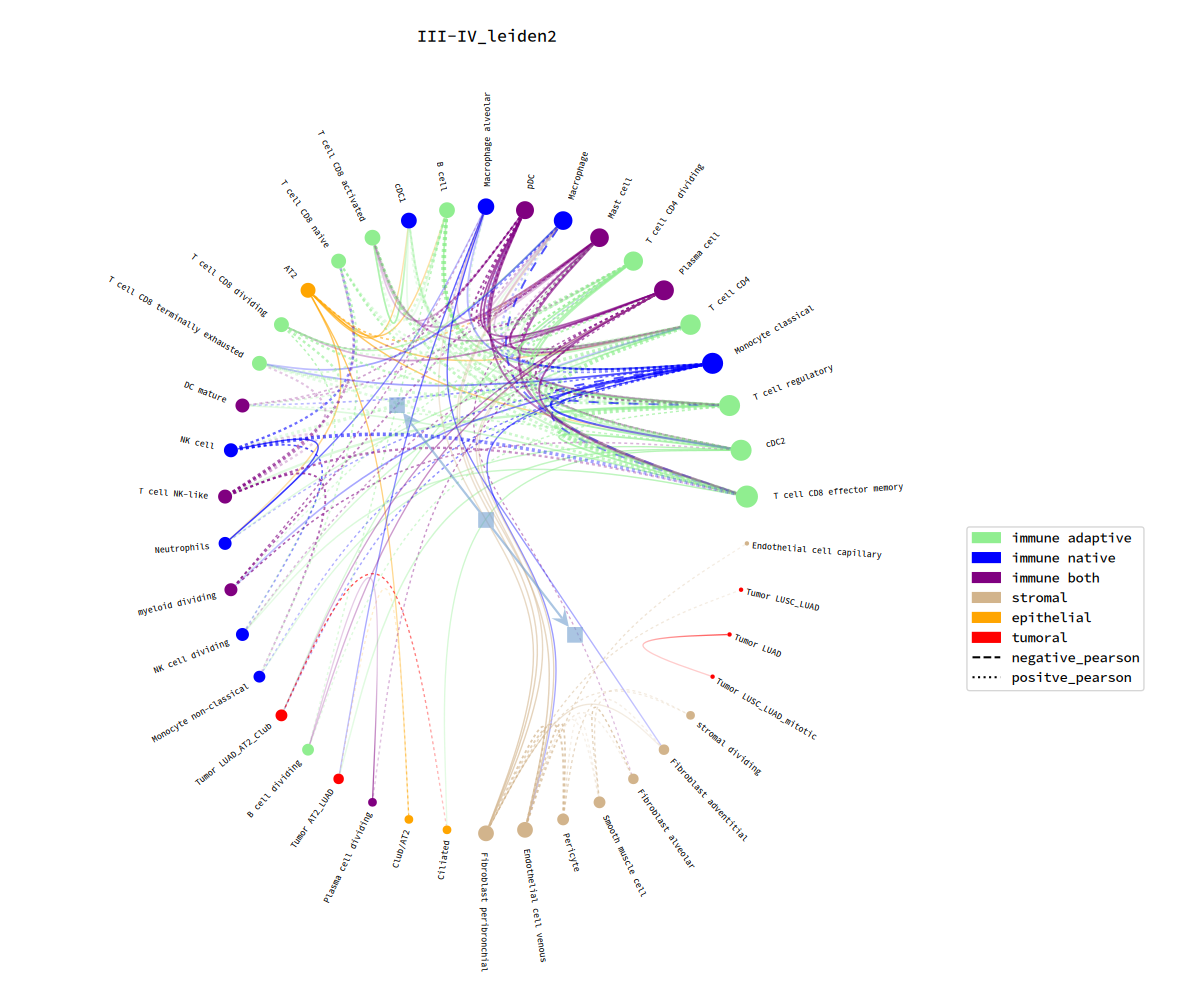

In [17]:
paint_net_from_state(state_late, g_late, "III-IV_leiden2", width_divisor=30)